# Determine Data Mapping Accuracy

#### Updated: March 21, 2023 by Ashley Ferreira

Note: there have been certain recent changes like the ability to read in from the log and work with the new categorization system, for which not all the documentation has been updated yet.

The purpose of this notebook is to determine the accuracy with which earlier notebooks are able to map the true values from the ionogram images to numpy arrays. This is done by following the steps:
1. Randomly load in sets of ionogram images.
2. Ask the user to specify if maximum depth point is properly estimated.
3. Use these inputs to estimate data mapping accuracy for the entire set of images, as well as potentially flag if there are certain directories or cases which have significantly better or significantly worse accuracies.
4. Visualize results. 

For now, this code is only available within the notebook but I have attempted to keep it somewhat modular so that it can be converted to a python file.

#### Import libraries and set global variables

In [1]:
#import plotly.express as px
import pandas as pd
import numpy as np
import os
import sys
import json

import random
from random import randrange
from IPython.display import clear_output

from matplotlib import pyplot as plt
from matplotlib import rcParams as rc
from matplotlib import rcParamsDefault
from matplotlib.ticker import MaxNLocator
import matplotlib.image as mpimg

rc.update(rcParamsDefault)

In [3]:
# potentially just make these global variables
resultDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/05_result/'
imageDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/04_processed/'
logDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/06_log/'

outFile = 'mapping_accuracy_results.csv'
append2outFile = True

sampling_method = 'log' # one of {'log', 'random'}

# only need to specify below for sampling_method = 'random'
sample_size = 10 # max sample from specific subdir
num_iters = 10 # number of times to to XXXX

# only need to specify below for sampling_method = 'log'
mappingLogDir = 'mapping_accuracy_log.csv' # older version of outFile

#### Initialize functions

In [4]:
def random_ionogram_data(roll, subdirectory, sample_list, imageDir=imageDir, resultDir=resultDir):
    '''
    This function will take in a list of images within the same subdirectory and 
    plot the origional ionigram scan next to the extracted data points. Information 
    from these data points is extracted, specifically minimum and maximum frequency
    as well as the location of the maximum depth. The user is then asked to classify
    the quality of data mapping based on this maximum depth location.

    Note: 
    1. Code is an adapted copy of inspect_ionograms() from notebook 08
    2. The function skips invalid images so if you request a sample size of 5 
       and 1 is an outlier it will only analyze the leftover 4

    Parameters:

        roll (str): ID for roll where subdirectory is located

        subdirectory (str): ID of subdirectory where images are located

        sample_list (lst): list of iongram scan image names

        imageDir (str, optional): directory of ionogram scan images

        resultsDir (str, optional): directory with results from processing images

    Returns:

        #features (lst): extrated points of interest (max_depth_lst, min_freq_lst, max_freq_lst)
        
        updated_sample_lst (lst): sample_list with names of invalid images removed
        
        acc_class (lst): main classification of data mapping (0, 1, or 2)
        
        sub_acc_class (lst): secondary classification of data mapping (A, B, or C)
    
    '''
    # read in list of mapped coordinates files as well as results csv file
    mapped_coords_list = os.listdir(resultDir + 'mapped_coords/' + roll + '/' + subdirectory + '/')
    df_result = pd.read_csv(resultDir + roll + '/result-' + roll + '_' + subdirectory + '.csv')
    
    # initialize lists to be filled in loop
    max_depth_lst, min_freq_lst, max_freq_lst = [], [], []
    updated_sample_lst, acc_class, sub_acc_class = [], [], []
    binary_accuracy_lst, max_depth_loc_lst = [], []

    not_counted_images = 0

    # loop over all image names given
    for image_fn in sample_list:
        print(image_fn)
        image_fn_ = image_fn.replace('.png', '')

        df_result_img = df_result.loc[df_result['filename'] == image_fn]

        # using error catching due to IndexError that happens
        try:

            # check if image type and exclude from analysis if loss or outlier
            img_class = df_result_img['processed_image_class'].iloc[0]
            if img_class == 'loss' or img_class == 'outlier':
                print('image classified as', img_class, ' and excluded from analysis \n\n')

            else:

                # initialize plot
                f, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,1.2],}, figsize=(25,5))

                for mapped_coord_fn in mapped_coords_list:
                    if '_' + image_fn_ + '.npy' in mapped_coord_fn:

                        # load data points for specific image
                        arr_load = np.load(resultDir + 'mapped_coords/' + roll + '/' + subdirectory + '/' + mapped_coord_fn)
                        df_plot = pd.DataFrame({
                        'f': arr_load[:, 0],
                        'depth': arr_load[:, 1]
                        })
                        df_plot['depth_plot'] = -1*df_plot['depth']

                        # extract data on points of interest
                        absolute_depth = np.abs(df_plot['depth_plot'])
                        min_depth = -1*min(absolute_depth)
                        max_depth = -1*max(absolute_depth)
                        min_freq = min(df_plot['f'])
                        max_freq = max(df_plot['f'])

                        max_depth_loc = np.argmax(absolute_depth)
                        freq_at_max_depth = df_plot['f'][max_depth_loc]

                        station_name = df_result_img['Station Name'].iloc[0]
                        year = df_result_img['year'].iloc[0]
                        if np.isfinite(year) and type(year)!=None:
                            year = int(year)
                        print(year, station_name)

                        # plot data points on left
                        axs[0].scatter(df_plot['f'], df_plot['depth_plot'], 1, color='black')
                        axs[0].set(xlabel='frequency (MHz)', ylabel='depth (km)')
                        axs[0].hlines(max_depth, min_freq, max_freq, linestyle='--', color='purple', label='max depth')
                        axs[0].vlines(freq_at_max_depth, max_depth, min_depth, linestyle='--', color='orange', label='frequency at max depth')
                        axs[0].legend(loc='best')
                        axs[0].grid()
                        axs[0].set_ylim(-1500, 0)
                        axs[0].set_xlim(0, 12)

                # plot image on right
                img = mpimg.imread(imageDir + roll + '/' + subdirectory + '/' + image_fn)
                axs[1].imshow(img, cmap='gray')
                axs[1].set(xticks=[], yticks=[])
                plt.show()

                # ask user for feedback on maximum depth estiamted location and mapping/image quality
                print('maximum depth found at (', round(freq_at_max_depth,2) , 'MHz,', round(max_depth,2), 'km )')
                category_entered = False
                sub_category_entered = False

                while category_entered == False:

                    print("Enter primary category (0 --> good, 2 --> bad):")
                    value = int(input())
                    print("you entered:", value)

                    if value == 0:
                        print("Enter frequency location of maximum depth (x to +/- 0.5 MHz):")
                        user_freq_max_depth = float(input())
                        print("you entered:", user_freq_max_depth)

                        print("Enter maximum depth (y to +/- 50 km):")
                        user_max_depth = float(input())
                        print("you entered:", user_max_depth)

                        category_entered = True

                    elif value == 2:
                        category_entered = True
                        user_freq_max_depth = 0
                        user_max_depth = 0
                    else:
                        print('incorrect category, must enter 0, 1, or 2')

                while sub_category_entered == False:

                    print("Enter subcategory (A, B, C, or D):")
                    sub_value = str(input())
                    print("you entered:", sub_value)

                    if sub_value == 'A' or sub_value == 'B' or sub_value == 'C' or sub_value == 'D':
                        sub_category_entered = True
                    else:
                        print('incorrect subcategory, must enter A, B, C or D')

                print('\n\n')

                # append values to lists 
                acc_class.append(value)
                updated_sample_lst.append(image_fn)
                sub_acc_class.append(sub_value)

                max_depth_loc = {"mapped_freq": round(freq_at_max_depth,2), "mapped_depth": round(max_depth,2), "user_freq": round(user_freq_max_depth,2), "user_depth": round(user_max_depth,2)}
                max_depth_loc_lst.append(max_depth_loc)

        except IndexError:
            print('IndexError occured, moving on to next image')

        except FileNotFoundError:
            print('FileNotFoundError occured, moving on to next image')

    return updated_sample_lst, acc_class, sub_acc_class, max_depth_loc_lst

In [5]:
def random_image_sample(roll, subdirectory, sample_size=sample_size, imageDir=imageDir):
    ''' 
    Given a roll and subdirectory, this function randomly samples
    a number of images specified by the sample_size variable. 

    Parameters:

        roll (str): ID for roll where subdirectory is located

        subdirectory (str): ID of subdirectory where images are located

        imageDir (str, optional): directory of ionogram scan images

        imageDir (str, optional): directory of ionogram scan images

    Returns:

        sample_list (lst): list of randomly selected images  
        
    '''
    images_lst = os.listdir(imageDir + roll + '/' + subdirectory + '/')

    # random sample will not duplicate choices
    sample_lst = random.sample(images_lst, sample_size)
    # catch value error here

    print('selected ionogram images:', sample_lst, '\n\n ~~~~~~~~~~~~~~~~~ \n')

    return sample_lst

In [6]:
def random_images(num_images=15, num_iters=1, roll=None, imageDir=imageDir, logDir=logDir, outFile=outFile):
    '''
    This function will randomly select a subdirectory and then randomly 
    select the specified number of random images from this directory. 
    This process if repeated num_iters times, therefore the total 
    number of images randomly selected is num_iters*num_images.

    Note: 
    1. The same subdirectory is not sampled from twice
    2. If there are less than num_images usable images in a subdirectory
       then the program will just select as many as it can. A similar 
       process will occur if there are less usable subdirectories to select
       than num_iters specified.

    Parameters:

        num_images (int): number of images to randomly select

        num_iters (int): number of times to iterate over the process

        roll (str, optional): roll to randomly select images from

        imageDir (str, optional): directory of ionogram scan images

        logDir (str, optional): directory of process_log.csv file

        outFile (str, optional): path and filename for outputted csv file

    Returns:

        None
        
    '''
    # read in log
    df_process_log = pd.read_csv(logDir + 'process_log.csv')

    # filter down to only specific role if specified
    if roll != None:
        df_process_log = df_process_log[df_process_log['Roll'] == roll]

    # create list of unique subdirectories
    subdir_ids_list = df_process_log['subdir_id'].unique()

    # initialized lists to track information
    roll_lst, subdir_lst, image_lst = [], [], []
    acc_class_lst, sub_acc_class_lst = [], []
    max_depth_loc_lst = []
    sampled_subdir_ids = []

    i = 0
    while i < num_iters:
        # randomly select one of the subdirectories 
        subdir_id = subdir_ids_list[randrange(len(subdir_ids_list))]

        # check that subdir has not already been sampled from
        if subdir_id in sampled_subdir_ids:
            # catch num_iters error here 

            continue

        else:
            i += 1
            sampled_subdir_ids.append(subdir_id)

            # parse id into actual subdir and roll names
            parts = subdir_id.split('_')
            roll = parts[0]
            subdirectory = parts[1]

            print('######################')
            print('interation:', i)
            print('roll:', roll)
            print('subdir:', subdirectory)

            # from sample ionogram images within subdirectory
            sample_list = random_image_sample(roll, subdirectory)
    
            # updated sample list returned incase certain images were invalid
            updated_sample_lst, acc_class, sub_acc_class, max_depth_locs = \
                random_ionogram_data(roll=roll, subdirectory=subdirectory, sample_list=sample_list, imageDir=imageDir, resultDir=resultDir)

            # save information df to csv
            #roll_lst = [roll]*num_images
            #subdir_lst = [subdirectory]*num_images

            for l in range(len(updated_sample_lst)): 
                # repeat this information for each entry
                roll_lst.append(roll)
                subdir_lst.append(subdirectory)
                
                # specific information to image
                image_lst.append(updated_sample_lst[l])
                max_depth_loc_lst.append(max_depth_locs[l])
                acc_class_lst.append(acc_class[l]) 
                sub_acc_class_lst.append(sub_acc_class[l]) 

            # initialize dataframe and save results to csv
            # (redoing this each interation to not loose information)
            # (append seems like it is being discontuined)
            df_mapping_results = pd.DataFrame()
            # can replace with concat like: vertical_concat = pd.concat([df1, df2], axis=0)

            df_mapping_results['roll'] = roll_lst
            df_mapping_results['subdir'] = subdir_lst
            df_mapping_results['image'] = image_lst
            df_mapping_results['max_depth_loc'] = max_depth_loc_lst
            df_mapping_results['acc_class'] = acc_class_lst
            df_mapping_results['sub_acc_class'] = sub_acc_class_lst

            # mode = 'a' means it will append to existing data within the file
            if append2outFile == True:
                mode = 'a' 

                # wipe lists now that they have been saved
                roll_lst, subdir_lst, image_lst = [], [], []
                acc_class_lst, sub_acc_class_lst = [], []
                max_depth_lst, min_freq_lst, max_freq_lst = [], [], []

                if os.path.exists(outFile):
                    header = False 
                else:
                    header = True
                
            else: 
                # this overwrites existing file
                mode = 'w'
                header = True
            df_mapping_results.to_csv(outFile, mode=mode, index=False, header=header) # add directory

            # clear notebook outputs for next iteration
            clear_output(wait=True)
            print('previous interation cleared but data saved to', outFile)

    print('done all iterations! run the following cells to analyze the results')

In [7]:
def log_images(mappingLogDir=mappingLogDir):
    '''
    This function will read in the roll, subdirectory, and image name
    for each entry in the mapping log and revisit each image to give 
    it a new categorization. Results are saveed to a seperate results file*

    *right now makes and saves a dataframe a end of each one so pretty inefficient

    Parameters:

        mappingLogDir (str, optional): path and filename for previous results csv file

    Returns:

        None
        
    '''
    # read in old mapping log
    df_mapping_log = pd.read_csv(mappingLogDir)

    log_rolls = df_mapping_log['roll']
    log_subdirs = df_mapping_log['subdir']
    log_image = df_mapping_log['image']

    visited_subdirs = []
    acc_class_lst, sub_acc_class_lst = [], []
    roll_lst, subdir_lst, image_lst = [], [], []
    max_depth_loc_lst = []
    
    for roll, subdirectory, image_fn in zip(log_rolls, log_subdirs, log_image):
        
        if not(subdirectory in visited_subdirs):
            visited_subdirs.append(subdirectory)
            print('######################')
            print('roll:', roll)
            print('subdir:', subdirectory)
        
            # read in list of mapped coordinates files as well as results csv file
            mapped_coords_list = os.listdir(resultDir + 'mapped_coords/' + roll + '/' + subdirectory + '/')
            df_result = pd.read_csv(resultDir + roll + '/result-' + roll + '_' + subdirectory + '.csv')

        print(image_fn)
        image_fn_ = image_fn.replace('.png', '')
        df_result_img = df_result.loc[df_result['filename'] == image_fn]

        # initialize plot
        f, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,1.2],}, figsize=(25,5))

        for mapped_coord_fn in mapped_coords_list:
            if '_' + image_fn_ + '.npy' in mapped_coord_fn:

                # load data points for specific image
                arr_load = np.load(resultDir + 'mapped_coords/' + roll + '/' + subdirectory + '/' + mapped_coord_fn)
                df_plot = pd.DataFrame({
                'f': arr_load[:, 0],
                'depth': arr_load[:, 1]
                })
                df_plot['depth_plot'] = -1*df_plot['depth']

                # extract data on points of interest
                absolute_depth = np.abs(df_plot['depth_plot'])
                min_depth = -1*min(absolute_depth)
                max_depth = -1*max(absolute_depth)
                min_freq = min(df_plot['f'])
                max_freq = max(df_plot['f'])

                max_depth_loc = np.argmax(absolute_depth)
                freq_at_max_depth = df_plot['f'][max_depth_loc]

                station_name = df_result_img['Station Name'].iloc[0]
                year = df_result_img['year'].iloc[0]
                if np.isfinite(year) and type(year)!=None:
                    year = int(year)
                print(year, station_name)

                # plot data points on left
                axs[0].scatter(df_plot['f'], df_plot['depth_plot'], 1, color='black')
                axs[0].set(xlabel='frequency (MHz)', ylabel='depth (km)')
                axs[0].hlines(max_depth, min_freq, max_freq, linestyle='--', color='purple', label='max depth')
                axs[0].vlines(freq_at_max_depth, max_depth, min_depth, linestyle='--', color='orange', label='frequency at max depth')
                axs[0].legend(loc='best')
                axs[0].grid()
                axs[0].set_ylim(-1500, 0)
                axs[0].set_xlim(0, 12)

        # plot image on right
        img = mpimg.imread(imageDir + roll + '/' + subdirectory + '/' + image_fn)
        axs[1].imshow(img, cmap='gray')
        axs[1].set(xticks=[], yticks=[])
        plt.show()

        # ask user for feedback on maximum depth estiamted location and mapping/image quality
        print('maximum depth found at (', round(freq_at_max_depth,2) , 'MHz,', round(max_depth,2), 'km )')
        category_entered = False
        sub_category_entered = False

        while category_entered == False:

            print("Enter primary category (0 --> good, 2 --> bad):")
            value = int(input())
            print("you entered:", value)

            if value == 0:
                print("Enter frequency location of maximum depth (x to +/- 0.5 MHz):")
                user_freq_max_depth = float(input())
                print("you entered:", user_freq_max_depth)

                print("Enter maximum depth (y to +/- 50 km):")
                user_max_depth = float(input())
                print("you entered:", user_max_depth)

                category_entered = True

            elif value == 2:
                category_entered = True
                user_freq_max_depth = 0
                user_max_depth = 0
            else:
                print('incorrect category, must enter 0, 1, or 2')

        while sub_category_entered == False:

            print("Enter subcategory (A, B, C, or D):")
            sub_value = str(input())
            print("you entered:", sub_value)

            if sub_value == 'A' or sub_value == 'B' or sub_value == 'C' or sub_value == 'D':
                sub_category_entered = True
            else:
                print('incorrect subcategory, must enter A, B, C or D')

        print('\n\n')

        # append values to lists 
        acc_class_lst.append(value)
        sub_acc_class_lst.append(sub_value)

        roll_lst.append(roll)
        subdir_lst.append(subdirectory)
        image_lst.append(image_fn)

        max_depth_loc = {"mapped_freq": round(freq_at_max_depth,2), "mapped_depth": round(max_depth,2), "user_freq": round(user_freq_max_depth,2), "user_depth": round(user_max_depth,2)}
        max_depth_loc_lst.append(max_depth_loc)

        # initialize dataframe and save results to csv
        # (redoing this each interation to not loose information)
        df_mapping_results = pd.DataFrame()

        df_mapping_results['roll'] = roll_lst
        df_mapping_results['subdir'] = subdir_lst
        df_mapping_results['image'] = image_lst
        df_mapping_results['max_depth_loc'] = max_depth_loc_lst
        df_mapping_results['acc_class'] = acc_class_lst
        df_mapping_results['sub_acc_class'] = sub_acc_class_lst

        # mode = 'a' means it will append to existing data within the file
        if append2outFile == True:
            mode = 'a' 

            # wipe lists now that they have been saved
            roll_lst, subdir_lst, image_lst = [], [], []
            acc_class_lst, sub_acc_class_lst = [], []
            max_depth_loc_lst = []

            if os.path.exists(outFile):
                header = False 
            else:
                header = True
            
        else: 
            # this overwrites existing file
            mode = 'w'
            header = True
        df_mapping_results.to_csv(outFile, mode=mode, index=False, header=header) # add directory

        # clear notebook outputs for next iteration
        clear_output(wait=True)
        print('previous interation cleared but data saved to', outFile)

    print('done all iterations! run the following cells to analyze the results')

#### Display sampled images

The ionograms contain three key pieces of information:
1. **Metadata**: listed outside of the main plot using printed numbers and at times just dots. We are not concerned with validating the metadata in this notebook as it is done elsewhere. 
2. **Depth**: the depth is displayed inverse-linearly on the y-axis, with each horizontal line signifying 100 km distance increments. There is a consistely dark line at the top of the plot which represents 0 km and therefore immediate reflection. There is often a hockey stick shape with tapering off near 1000 km (996 km to 1032 km), which signifies the approximate location of the Earth's surface. 
3. **Frequency**: the frequency is not displayed in a consistent linear scale like the depth but the vertical lines are at known MHz values.

From what I have seen so far all ionograms will follow the same identical x and y axis even is metadata can be placed in different positions with respect to these axes. 

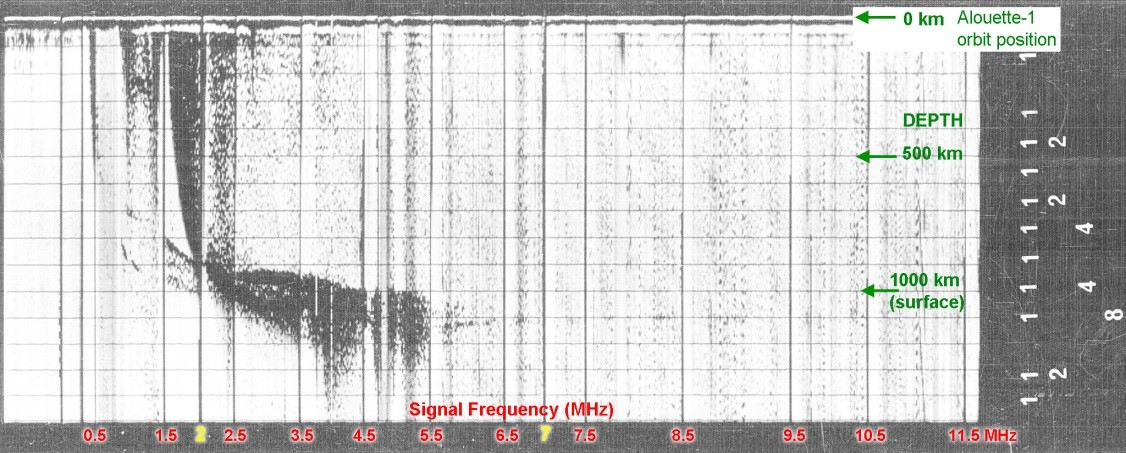

In [ ]:
# don't rerun this cell if you do not have image file
from IPython.display import Image
Image(filename=os.getcwd()+'\\ionogram_markers.jpg') 

The labelled figure above is taken from the Data Specifications Alouette-I Ionograms document.

The goal is for the user to find images where this hockey stick type structure exists and it is clear where the maximum depth location of this structure is.

User enters 0 or 2 for the following categories:
- 0 if resonably confident in maximum depth location of hockey stick structure*. Ability to flag possibe issues with data mapping at maximum depth point: 
    * A for mapping issue
    * B for thresholding issue (e.g. too much noise or grid line picked up on, or too little data from hockey strick structure included)
    * C for combination of A & B
    * D for other or no significant issues identified
- 2 if unsure of maximum depth location. Reasons for unsure: 
    * A for bad ionogram image or scan (can't confidently read off data, might just be too much noise, overexposed, or may even have writting on it)
    * B for no clear hockey stick structure in ionogram or a fade out near maximum depth point makes it hard to pinpoint it
    * C for combination of A & B
    * D for other or weird cases (e.g. long image that is hard to read off of without zooming in, much thicker than normal grid lines or artificats exist, hockey stick structure coming in from right hand side)
    
And once one of these categories is selected they will be prompted for the sub-category (A, B, or C).

*if the user entered 0 they will be prompted to enter the estimated maximum depth position of the hockey stick structure, specifically:
- The x-axis coordinate in MHz to +/- 0.5 MHz precision
- The y-axis coordinate in km to +/- 50 km precision, please include the negative sign to be consistent with the y-axis


######################
roll: R014207967
subdir: 1487-1B
102.png
1963 Resolute Bay, No.W.Territories


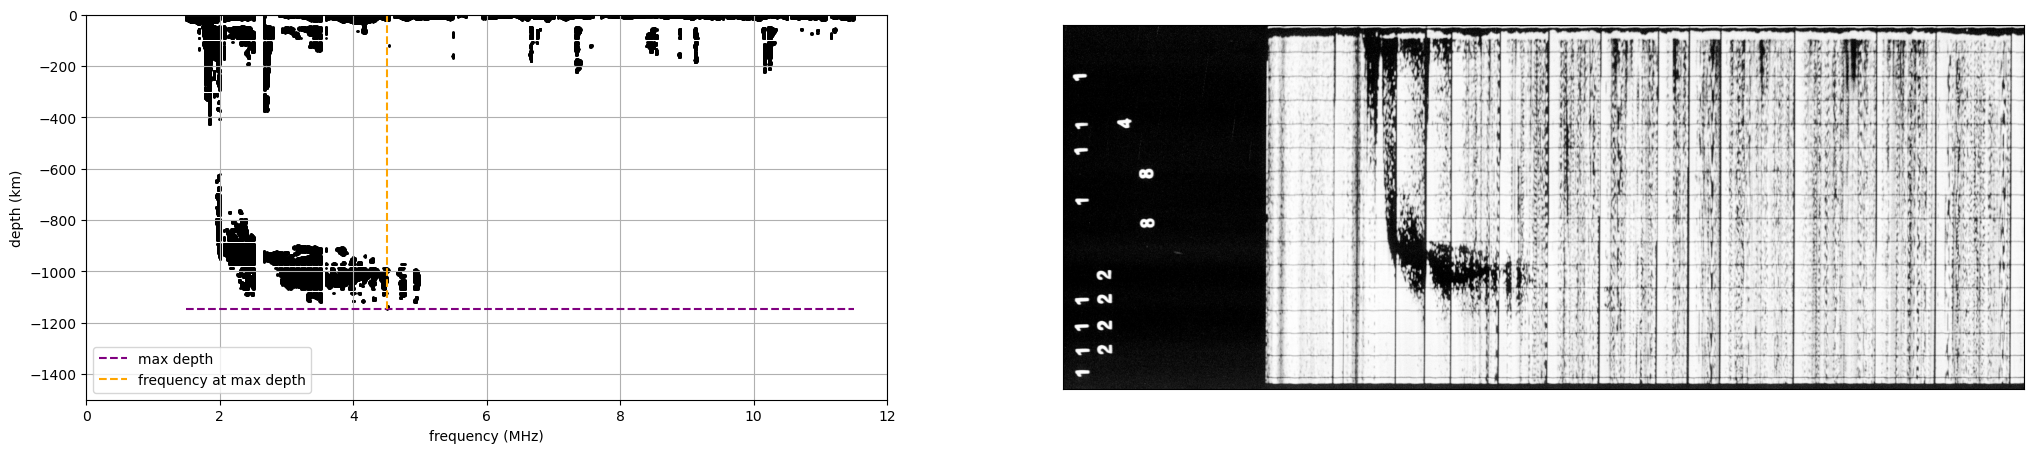

maximum depth found at ( 4.51 MHz, -1146.15 km )
Enter primary category (0 --> good, 2 --> bad):


In [10]:
if sampling_method == 'random':
    random_images(num_iters=num_iters) 

elif sampling_method == 'log':
    log_images()

Note that the program may throw a "file not found" error if you have not navigated to the L drive recently.

The date printed for each ionogram next to the ground station has not been confirmed and this metadata reading is currently being assessed for accuracy.

#### Analyze results

In [ ]:
# read back in mapping accuracy csv file
df_mapping_results = pd.read_csv('mapping_accuracy_results.csv') 
df_mapping_results.reset_index(drop=True) # this takes index column off
df_mapping_results.head(2000)

In [ ]:
# ask for threshold and calculate x and y accuracy by shifting values to category 1
y_bounds = 100.0 # +/- this amount in km is acceptable, minimum 50
x_bounds = 1.0 # +/- this amount in Hz is acceptable, minimum 0.5

acc_class_lst = df_mapping_results['acc_class']
sub_acc_class_lst = df_mapping_results['sub_acc_class']
max_depth_loc_lst = df_mapping_results['max_depth_loc']

new_acc_class_lst = []
new_sub_acc_class_lst = []

for acc_class, sub_acc_class, depth_loc in zip(acc_class_lst, sub_acc_class_lst, max_depth_loc_lst):
    depth_loc = depth_loc.replace("\'", "\"") # to be able to read as dictionary
    depth_loc = json.loads(str(depth_loc))

    mapped_freq = depth_loc['mapped_freq']
    mapped_depth = depth_loc['mapped_depth']
    user_freq = depth_loc['user_freq']
    user_depth = depth_loc['user_depth']

    if abs(mapped_freq-user_freq) < x_bounds:
        acc_class = 1 
        sub_acc_class = 'A'

    if abs(mapped_depth-user_depth) < y_bounds:
        if sub_acc_class == 'A' and acc_class == 1:
            sub_acc_class = 'C'
        else:
            sub_acc_class = 'B'

        acc_class = 1 

    new_acc_class_lst.append(acc_class)
    new_sub_acc_class_lst.append(sub_acc_class)

df_mapping_results['acc_class'] = new_acc_class_lst
df_mapping_results['sub_acc_class'] = new_sub_acc_class_lst
df_mapping_results.head()

The codeblock above adds a new primary class called 1 which also has an A, B, and C subclass and images are migrated to these new categories as follows:
- 1 if the x and/or y minimum depth coordinate is within the acceptable bounds:
   * A if just the x coordinate is within the acceptable bounds
   * B if just the y coordinate is within the acceptable bounds
   * C if both x and y are within the acceptable bounds
- otherwise classification stays the same

No matter what the results document is not updated to reflect this new classification. 


The category 2 will not be included in the rough accuracy calculation. This binairy accuracy is calculated as
$$ A = \frac{N_1}{N_1 + N_0} \times 100 \% $$
where $N_0$ is the number of ionograms categorized as 0, and similarly $N_1$ is the number of ionograms categorized as 1.

In [22]:
# create summary statistics overall and for each roll
def bi_acc(df, option='one'):
    ''' 
    NOT YET UPDATED FOR NEW SYSTEM

    Using -1 as code for if all of them were a mix of outlier, loss and category 2

    option (str, optional): 
        'one' --> only one coordinate (x or y) needs to be correct to be accurate
        'both' --> both coordinates (x and y) need to be correct to be accurate
        'x' --> only x needs to be correct to be accurate
        'y' --> only x needs to be correct to be accurate
    '''

    acc_class_lst = df['acc_class']
    sub_acc_class_lst = df['sub_acc_class']
    bi_acc_parts = []

    c2AorC = 0
    for c, sub in zip(acc_class_lst, sub_acc_class_lst):
        c = int(c)

        if c != 2: # don't include category 2 in calculation

            if option == 'one':
                #if c == 1 or c == 0:
                bi_acc_parts.append(c)

            elif option == 'both':
                if c == 1 and sub == 'C':
                    bi_acc_parts.append(1)
                else:
                    bi_acc_parts.append(0)

            elif option == 'x':
                if c == 1 and sub != 'B':
                    bi_acc_parts.append(1)
                else:
                    bi_acc_parts.append(0)

            elif option == 'y':
                if c == 1 and sub != 'A':
                    bi_acc_parts.append(1)
                else:
                    bi_acc_parts.append(0)

        else:
            if sub == 'A' or sub == 'C':
                c2AorC += 1

    # calculate percentage of 2A adn 2C out of total
    print('2AorC', c2AorC)

    if len(bi_acc_parts) == 0:
        overall_acc = -1
        print('not able to calculate acuracy, coded as -1%') 
    else:
        overall_acc = 100*sum(bi_acc_parts)/len(bi_acc_parts)
    print('binary accuracy:', round(overall_acc, 2),  '%')

    return overall_acc

In [23]:
print('x-axis accuracy')
print('OVERALL')
bi_acc(df_mapping_results, option='x')

print('############')
print('ROLL SPECIFIC')
rolls = df_mapping_results.roll.unique()
roll_acc = [] 
for r in rolls:
    print('for', r)
    sub_df = df_mapping_results.loc[df_mapping_results['roll'] == r]
    roll_acc.append(bi_acc(sub_df, option='x'))

x-axis accuracy
OVERALL
2AorC 0
binary accuracy: 0.0 %
############
ROLL SPECIFIC
for R014207940F
2AorC 0
binary accuracy: 0.0 %


In [ ]:
print('y-axis accuracy')
print('OVERALL')
bi_acc(df_mapping_results, option='y')

print('############')
print('ROLL SPECIFIC')
rolls = df_mapping_results.roll.unique()
roll_acc = [] 
for r in rolls:
    print('for', r)
    sub_df = df_mapping_results.loc[df_mapping_results['roll'] == r]
    roll_acc.append(bi_acc(sub_df, option='y'))

In [ ]:
print('combined x and y-axis accuracy')
print('OVERALL')
bi_acc(df_mapping_results, option='both')

print('############')
print('ROLL SPECIFIC')
rolls = df_mapping_results.roll.unique()
roll_acc = [] 
for r in rolls:
    print('for', r)
    sub_df = df_mapping_results.loc[df_mapping_results['roll'] == r]
    roll_acc.append(bi_acc(sub_df, option='both'))

In [33]:
# set plot style
# can check avail ones using: print(plt.style.available)
style1 = 'tableau-colorblind10'
style2 = 'seaborn-colorblind'
style3 = 'ggplot'
plt.style.use(style3)

In [34]:
# sum total for all classes
df_mapping_results['acc_class'] = df_mapping_results['acc_class'].map(str)

# count 1
c1 = len(df_mapping_results.loc[df_mapping_results['acc_class'] == '1'])
c1A = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '1') & (df_mapping_results['sub_acc_class'] == 'A')])
c1B = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '1') & (df_mapping_results['sub_acc_class'] == 'B')])
c1C = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '1') & (df_mapping_results['sub_acc_class'] == 'C')])
#print(c1, c1A, c1B, c1C)

# count 2
c2 = len(df_mapping_results.loc[df_mapping_results['acc_class'] == '2'])
c2A = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '2') & (df_mapping_results['sub_acc_class'] == 'A')])
c2B = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '2') & (df_mapping_results['sub_acc_class'] == 'B')])
c2C = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '2') & (df_mapping_results['sub_acc_class'] == 'C')])
c2D = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '2') & (df_mapping_results['sub_acc_class'] == 'D')])
#print(c2, c2A, c2B, c2C)

# count 0
c0 = len(df_mapping_results.loc[df_mapping_results['acc_class'] == '0'])
c0A = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '0') & (df_mapping_results['sub_acc_class'] == 'A')])
c0B = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '0') & (df_mapping_results['sub_acc_class'] == 'B')])
c0C = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '0') & (df_mapping_results['sub_acc_class'] == 'C')])
c0D = len(df_mapping_results.loc[(df_mapping_results['acc_class'] == '0') & (df_mapping_results['sub_acc_class'] == 'D')])
#print(c0, c0A, c0B, c0C)

In [ ]:
# pie chart for classes (ideally make a nested one)
class_names = ['(0) incorrect max depth', '(1) correct max depth', '(2) other']
data = [c0, c1, c2]
fig = plt.figure(figsize =(8, 7))
plt.pie(data, labels=class_names, autopct='%0.f%%')
plt.legend(loc='upper left')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.axis('equal')
width = 0.3

cm = plt.get_cmap("tab20c")
cout = cm(np.arange(3)*4)
pie, _ = ax.pie(data, radius=1, labels=list("012"), colors=cout)
plt.setp( pie, width=width, edgecolor='white')

sub_data = [c0A, c0B, c0C, c0D, c1A, c1B, c1C, c2A, c2B, c2C, c2D]
cin = cm(np.array([1,2,3,5,6,7,8,9,10,11,12]))
labels = ['0A', '0B', '0C', '0D', '1A', '1B', '1C', '2A', '2B', '2C', '2D']
pie2, _ = ax.pie(sub_data, radius=1-width, labels=labels, colors=cin)
plt.setp(pie2, width=width, edgecolor='white')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

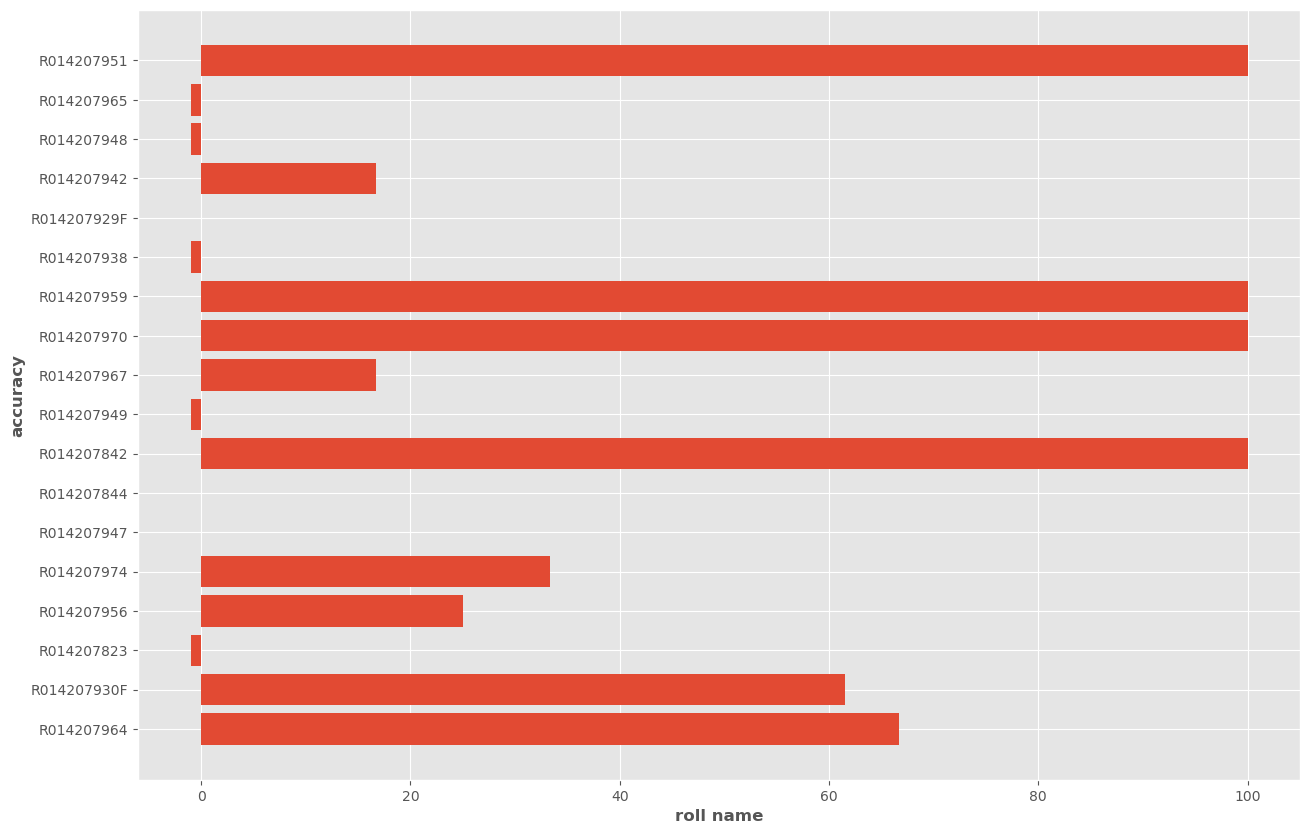

In [47]:
# bar chart for roll accuracies
# (ideally also stacked bar chart with subclass info)
fig = plt.figure(figsize =(15, 10))
plt.barh(rolls, roll_acc)
plt.xlabel('roll name', fontweight='bold')
plt.ylabel('accuracy', fontweight='bold')
plt.show()
fig.savefig('acc_hbar.png')

In [ ]:
# bar chart for roll classes and subclasses

barWidth = 0.25
fig = plt.subplots(figsize =(10, 5))
 
cA_l = [c0A, c1A, c2A]
cB_l = [c0B, c1B, c2B]
cC_l = [c0C, c1C, c2C]
cD_l = [c0D, 0, c2D]
 
br1 = np.arange(len(cA_l))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
plt.bar(br1, cA_l, width = barWidth,
        edgecolor ='grey', label ='A')
plt.bar(br2, cB_l, width = barWidth,
        edgecolor ='grey', label ='B')
plt.bar(br3, cC_l, width = barWidth,
        edgecolor ='grey', label ='C')
plt.bar(br4, cD_l, width = barWidth,
        edgecolor ='grey', label ='D')
 
plt.xlabel('Classification', fontweight ='bold')
plt.ylabel('Number of Images', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(cA_l))],
        ['0','1','2'])
 
plt.legend()
plt.show()

#### Read in results summary file
This file gives the high-level stats for all the processed ionograms. A warning that this is a very large CSV file an the code block below will likely take a few minutes to complete.

In [87]:
# only loading in a subsection of the full results (not same 5 as above yet)
df_results_sum = pd.read_csv(resultDir + 'result_total_mdrp.csv', nrows=5)
df_results_sum.head()

,fmin_Run1,max_depth_Run1,satellite_number_Run1,year_Run1,day_Run1,hour_Run1,minute_Run1,second_Run1,station_number_Run1,Station Name_Run1,...,y_centroids_Run1_md,is_dot_Run1_md,dict_metadata_Run1_md,details_Run1_md,Roll_Run1_md,Subdirectory_Run1_md,filename_Run1_md,rotated_metadata_Run1,station_code_Run1,station_code_Run1_md
0,1.5,387.500000,1.0,1961.0,3.0,2.0,2.0,3.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,10.png,NaN,NaN,NaN
1,1.5,556.250000,1.0,1961.0,2.0,2.0,2.0,3.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,101.png,NaN,NaN,NaN
2,1.5,654.166667,0.0,1960.0,2.0,2.0,3.0,2.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,102.png,NaN,NaN,NaN
3,1.5,504.166667,0.0,1960.0,2.0,2.0,3.0,2.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,106.png,NaN,NaN,NaN
4,1.5,504.166667,0.0,1961.0,2.0,2.0,2.0,3.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,107.png,NaN,NaN,NaN


In [5]:
# exploring the column names
# (75 is too many to see in table preview)
for col in df_results_sum.columns:
    print(col)

fmin_Run1
max_depth_Run1
satellite_number_Run1
year_Run1
day_Run1
hour_Run1
minute_Run1
second_Run1
station_number_Run1
Station Name_Run1
3 - Letter Code_Run1
LAT._Run1
LONG. _Run1
processed_image_class_Run1
func_name_Run1
limits_Run1
height_Run1
width_Run1
metadata_type_Run1
meta_height_Run1
meta_width_Run1
x_centroids_Run1
y_centroids_Run1
is_dot_Run1
dict_metadata_Run1
raw_coord_Run1
window_coord_Run1
mapping_Hz_Run1
mapping_km_Run1
details_Run1
Roll
Subdirectory
filename
satellite_number_Run1_md
year_Run1_md
day_1_Run1_md
day_2_Run1_md
day_3_Run1_md
hour_1_Run1_md
hour_2_Run1_md
minute_1_Run1_md
minute_2_Run1_md
second_1_Run1_md
second_2_Run1_md
station_number_1_Run1_md
station_number_2_Run1_md
day_Run1_md
hour_Run1_md
minute_Run1_md
second_Run1_md
station_number_Run1_md
Station Name_Run1_md
3 - Letter Code_Run1_md
LAT._Run1_md
LONG. _Run1_md
processed_image_class_Run1_md
func_name_Run1_md
limits_Run1_md
height_Run1_md
width_Run1_md
metadata_type_Run1_md
meta_height_Run1_md
meta_wi